# ML for Gas Adsorption

## -1. Only if you run this notebook on Colab

If you use this notebook on Colab, please uncomment the lines below (remove the `#`) and execute the cell.

In [1]:
#import sys
#!{sys.executable} -m pip install -U pandas-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension
#!pip install --upgrade pandas sklearn holoviews bokeh plotly matplotlib
#!wget https://raw.githubusercontent.com/kjappelbaum/ml_molsim/2022/descriptornames.py
#!mkdir data
#!cd data && wget https://github.com/kjappelbaum/ml_molsim/raw/2022/data/data.csv
#!cd data && wget https://github.com/kjappelbaum/ml_molsim/raw/2022/data/features.csv
# import os, holoviews as hv
# os.environ['HV_DOC_HTML'] = 'true'

## Import packages we will need

In [3]:
# basics
import os
import numpy as np
import pprint as pp
import seaborn as sns

# pandas is used to read/process data
import pandas as pd

# machine learning dependencies
# scaling of data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# train/test split
from sklearn.model_selection import train_test_split
# model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# the KRR model
from sklearn.kernel_ridge import KernelRidge
# linear model
from sklearn.linear_model import LinearRegression
# pipeline to streamline modeling pipelines
from sklearn.pipeline import Pipeline
# principal component analysis
from sklearn.decomposition import PCA
# polynomial kernel
from sklearn.metrics.pairwise import polynomial_kernel
# Dummy model as baseline
from sklearn.dummy import DummyClassifier, DummyRegressor
# Variance Threshold for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
# metrics to measure model performance
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, max_error)

# save/load models
import joblib

# For the permutation importance implementation
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import check_scoring
from sklearn.utils import Bunch
from sklearn.utils import check_random_state
from sklearn.utils import check_array

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
from pymatviz.histogram import histogram

RANDOM_SEED = 4242424242
DATA_DIR = './'
DATA_FILE = os.path.join(DATA_DIR, 'data.csv')

np.random.seed(RANDOM_SEED)


In [5]:

other_descriptors = ["CellV [A^3]"]

geometric_descriptors = [
    "Di",
    "Df",
    "Dif",
    "density [g/cm^3]",
    "total_SA_volumetric",
    "total_SA_gravimetric",
    "total_POV_volumetric",
    "total_POV_gravimetric",
]

linker_descriptors = [
    "f-lig-chi-0",
    "f-lig-chi-1",
    "f-lig-chi-2",
    "f-lig-chi-3",
    "f-lig-Z-0",
    "f-lig-Z-1",
    "f-lig-Z-2",
    "f-lig-Z-3",
    "f-lig-I-0",
    "f-lig-I-1",
    "f-lig-I-2",
    "f-lig-I-3",
    "f-lig-T-0",
    "f-lig-T-1",
    "f-lig-T-2",
    "f-lig-T-3",
    "f-lig-S-0",
    "f-lig-S-1",
    "f-lig-S-2",
    "f-lig-S-3",
    "lc-chi-0-all",
    "lc-chi-1-all",
    "lc-chi-2-all",
    "lc-chi-3-all",
    "lc-Z-0-all",
    "lc-Z-1-all",
    "lc-Z-2-all",
    "lc-Z-3-all",
    "lc-I-0-all",
    "lc-I-1-all",
    "lc-I-2-all",
    "lc-I-3-all",
    "lc-T-0-all",
    "lc-T-1-all",
    "lc-T-2-all",
    "lc-T-3-all",
    "lc-S-0-all",
    "lc-S-1-all",
    "lc-S-2-all",
    "lc-S-3-all",
    "lc-alpha-0-all",
    "lc-alpha-1-all",
    "lc-alpha-2-all",
    "lc-alpha-3-all",
    "D_lc-chi-0-all",
    "D_lc-chi-1-all",
    "D_lc-chi-2-all",
    "D_lc-chi-3-all",
    "D_lc-Z-0-all",
    "D_lc-Z-1-all",
    "D_lc-Z-2-all",
    "D_lc-Z-3-all",
    "D_lc-I-0-all",
    "D_lc-I-1-all",
    "D_lc-I-2-all",
    "D_lc-I-3-all",
    "D_lc-T-0-all",
    "D_lc-T-1-all",
    "D_lc-T-2-all",
    "D_lc-T-3-all",
    "D_lc-S-0-all",
    "D_lc-S-1-all",
    "D_lc-S-2-all",
    "D_lc-S-3-all",
    "D_lc-alpha-0-all",
    "D_lc-alpha-1-all",
    "D_lc-alpha-2-all",
    "D_lc-alpha-3-all",
]

metalcenter_descriptors = [
    "mc_CRY-chi-0-all",
    "mc_CRY-chi-1-all",
    "mc_CRY-chi-2-all",
    "mc_CRY-chi-3-all",
    "mc_CRY-Z-0-all",
    "mc_CRY-Z-1-all",
    "mc_CRY-Z-2-all",
    "mc_CRY-Z-3-all",
    "mc_CRY-I-0-all",
    "mc_CRY-I-1-all",
    "mc_CRY-I-2-all",
    "mc_CRY-I-3-all",
    "mc_CRY-T-0-all",
    "mc_CRY-T-1-all",
    "mc_CRY-T-2-all",
    "mc_CRY-T-3-all",
    "mc_CRY-S-0-all",
    "mc_CRY-S-1-all",
    "mc_CRY-S-2-all",
    "mc_CRY-S-3-all",
    "D_mc_CRY-chi-0-all",
    "D_mc_CRY-chi-1-all",
    "D_mc_CRY-chi-2-all",
    "D_mc_CRY-chi-3-all",
    "D_mc_CRY-Z-0-all",
    "D_mc_CRY-Z-1-all",
    "D_mc_CRY-Z-2-all",
    "D_mc_CRY-Z-3-all",
    "D_mc_CRY-I-0-all",
    "D_mc_CRY-I-1-all",
    "D_mc_CRY-I-2-all",
    "D_mc_CRY-I-3-all",
    "D_mc_CRY-T-0-all",
    "D_mc_CRY-T-1-all",
    "D_mc_CRY-T-2-all",
    "D_mc_CRY-T-3-all",
    "D_mc_CRY-S-0-all",
    "D_mc_CRY-S-1-all",
    "D_mc_CRY-S-2-all",
    "D_mc_CRY-S-3-all",
]

functionalgroup_descriptors = [
    "func-chi-0-all",
    "func-chi-1-all",
    "func-chi-2-all",
    "func-chi-3-all",
    "func-Z-0-all",
    "func-Z-1-all",
    "func-Z-2-all",
    "func-Z-3-all",
    "func-I-0-all",
    "func-I-1-all",
    "func-I-2-all",
    "func-I-3-all",
    "func-T-0-all",
    "func-T-1-all",
    "func-T-2-all",
    "func-T-3-all",
    "func-S-0-all",
    "func-S-1-all",
    "func-S-2-all",
    "func-S-3-all",
    "func-alpha-0-all",
    "func-alpha-1-all",
    "func-alpha-2-all",
    "func-alpha-3-all",
    "D_func-chi-0-all",
    "D_func-chi-1-all",
    "D_func-chi-2-all",
    "D_func-chi-3-all",
    "D_func-Z-0-all",
    "D_func-Z-1-all",
    "D_func-Z-2-all",
    "D_func-Z-3-all",
    "D_func-I-0-all",
    "D_func-I-1-all",
    "D_func-I-2-all",
    "D_func-I-3-all",
    "D_func-T-0-all",
    "D_func-T-1-all",
    "D_func-T-2-all",
    "D_func-T-3-all",
    "D_func-S-0-all",
    "D_func-S-1-all",
    "D_func-S-2-all",
    "D_func-S-3-all",
    "D_func-alpha-0-all",
    "D_func-alpha-1-all",
    "D_func-alpha-2-all",
    "D_func-alpha-3-all",
]


summed_linker_descriptors = [
    "sum-f-lig-chi-0",
    "sum-f-lig-chi-1",
    "sum-f-lig-chi-2",
    "sum-f-lig-chi-3",
    "sum-f-lig-Z-0",
    "sum-f-lig-Z-1",
    "sum-f-lig-Z-2",
    "sum-f-lig-Z-3",
    "sum-f-lig-I-0",
    "sum-f-lig-I-1",
    "sum-f-lig-I-2",
    "sum-f-lig-I-3",
    "sum-f-lig-T-0",
    "sum-f-lig-T-1",
    "sum-f-lig-T-2",
    "sum-f-lig-T-3",
    "sum-f-lig-S-0",
    "sum-f-lig-S-1",
    "sum-f-lig-S-2",
    "sum-f-lig-S-3",
    "sum-lc-chi-0-all",
    "sum-lc-chi-1-all",
    "sum-lc-chi-2-all",
    "sum-lc-chi-3-all",
    "sum-lc-Z-0-all",
    "sum-lc-Z-1-all",
    "sum-lc-Z-2-all",
    "sum-lc-Z-3-all",
    "sum-lc-I-0-all",
    "sum-lc-I-1-all",
    "sum-lc-I-2-all",
    "sum-lc-I-3-all",
    "sum-lc-T-0-all",
    "sum-lc-T-1-all",
    "sum-lc-T-2-all",
    "sum-lc-T-3-all",
    "sum-lc-S-0-all",
    "sum-lc-S-1-all",
    "sum-lc-S-2-all",
    "sum-lc-S-3-all",
    "sum-lc-alpha-0-all",
    "sum-lc-alpha-1-all",
    "sum-lc-alpha-2-all",
    "sum-lc-alpha-3-all",
    "sum-D_lc-chi-0-all",
    "sum-D_lc-chi-1-all",
    "sum-D_lc-chi-2-all",
    "sum-D_lc-chi-3-all",
    "sum-D_lc-Z-0-all",
    "sum-D_lc-Z-1-all",
    "sum-D_lc-Z-2-all",
    "sum-D_lc-Z-3-all",
    "sum-D_lc-I-0-all",
    "sum-D_lc-I-1-all",
    "sum-D_lc-I-2-all",
    "sum-D_lc-I-3-all",
    "sum-D_lc-T-0-all",
    "sum-D_lc-T-1-all",
    "sum-D_lc-T-2-all",
    "sum-D_lc-T-3-all",
    "sum-D_lc-S-0-all",
    "sum-D_lc-S-1-all",
    "sum-D_lc-S-2-all",
    "sum-D_lc-S-3-all",
    "sum-D_lc-alpha-0-all",
    "sum-D_lc-alpha-1-all",
    "sum-D_lc-alpha-2-all",
    "sum-D_lc-alpha-3-all",
]

summed_metalcenter_descriptors = [
    "sum-mc_CRY-chi-0-all",
    "sum-mc_CRY-chi-1-all",
    "sum-mc_CRY-chi-2-all",
    "sum-mc_CRY-chi-3-all",
    "sum-mc_CRY-Z-0-all",
    "sum-mc_CRY-Z-1-all",
    "sum-mc_CRY-Z-2-all",
    "sum-mc_CRY-Z-3-all",
    "sum-mc_CRY-I-0-all",
    "sum-mc_CRY-I-1-all",
    "sum-mc_CRY-I-2-all",
    "sum-mc_CRY-I-3-all",
    "sum-mc_CRY-T-0-all",
    "sum-mc_CRY-T-1-all",
    "sum-mc_CRY-T-2-all",
    "sum-mc_CRY-T-3-all",
    "sum-mc_CRY-S-0-all",
    "sum-mc_CRY-S-1-all",
    "sum-mc_CRY-S-2-all",
    "sum-mc_CRY-S-3-all",
    "sum-D_mc_CRY-chi-0-all",
    "sum-D_mc_CRY-chi-1-all",
    "sum-D_mc_CRY-chi-2-all",
    "sum-D_mc_CRY-chi-3-all",
    "sum-D_mc_CRY-Z-0-all",
    "sum-D_mc_CRY-Z-1-all",
    "sum-D_mc_CRY-Z-2-all",
    "sum-D_mc_CRY-Z-3-all",
    "sum-D_mc_CRY-I-0-all",
    "sum-D_mc_CRY-I-1-all",
    "sum-D_mc_CRY-I-2-all",
    "sum-D_mc_CRY-I-3-all",
    "sum-D_mc_CRY-T-0-all",
    "sum-D_mc_CRY-T-1-all",
    "sum-D_mc_CRY-T-2-all",
    "sum-D_mc_CRY-T-3-all",
    "sum-D_mc_CRY-S-0-all",
    "sum-D_mc_CRY-S-1-all",
    "sum-D_mc_CRY-S-2-all",
    "sum-D_mc_CRY-S-3-all",
]

summed_functionalgroup_descriptors = [
    "sum-func-chi-0-all",
    "sum-func-chi-1-all",
    "sum-func-chi-2-all",
    "sum-func-chi-3-all",
    "sum-func-Z-0-all",
    "sum-func-Z-1-all",
    "sum-func-Z-2-all",
    "sum-func-Z-3-all",
    "sum-func-I-0-all",
    "sum-func-I-1-all",
    "sum-func-I-2-all",
    "sum-func-I-3-all",
    "sum-func-T-0-all",
    "sum-func-T-1-all",
    "sum-func-T-2-all",
    "sum-func-T-3-all",
    "sum-func-S-0-all",
    "sum-func-S-1-all",
    "sum-func-S-2-all",
    "sum-func-S-3-all",
    "sum-func-alpha-0-all",
    "sum-func-alpha-1-all",
    "sum-func-alpha-2-all",
    "sum-func-alpha-3-all",
    "sum-D_func-chi-0-all",
    "sum-D_func-chi-1-all",
    "sum-D_func-chi-2-all",
    "sum-D_func-chi-3-all",
    "sum-D_func-Z-0-all",
    "sum-D_func-Z-1-all",
    "sum-D_func-Z-2-all",
    "sum-D_func-Z-3-all",
    "sum-D_func-I-0-all",
    "sum-D_func-I-1-all",
    "sum-D_func-I-2-all",
    "sum-D_func-I-3-all",
    "sum-D_func-T-0-all",
    "sum-D_func-T-1-all",
    "sum-D_func-T-2-all",
    "sum-D_func-T-3-all",
    "sum-D_func-S-0-all",
    "sum-D_func-S-1-all",
    "sum-D_func-S-2-all",
    "sum-D_func-S-3-all",
    "sum-D_func-alpha-0-all",
    "sum-D_func-alpha-1-all",
    "sum-D_func-alpha-2-all",
    "sum-D_func-alpha-3-all",
]


 ${\textsf{Short question}}$
- We declared a global variable to fix the random seed (`RANDOM_SEED`). Why did we do this?  

 ${\textsf{Answer}}$

The parts that are interesting for this question is the following part: 
<div align="center">

```python
RANDOM_SEED = 4242424242
np.random.seed(RANDOM_SEED)
```
<div align = "left">

The seed function allows us to assure reproductibility of the experiment. In other word, the intergers chosen at random would be the same each time the project is run. The global variable here is set to 4242424242, however the code would still work for any other integer numbers. Its importance can also be noted later on as this also allows the same datasets to be chosen for the training set and the test set each time. 

## Hands-on Project: Carbon-dioxide uptake in MOFs

In this exercise we will build a model that can predict the $CO_2$ uptake of metal-organic frameworks (MOFs), which are crystalline materials consisting of inorganic metal nodes linked by organic linkers.

![MOF building principle](assets/mof_building_principle.png)

There are two main **learning goals** for this exercise: 

1. Understand the typical workflow for machine learning in materials science. We will cover exploratory data analysis (EDA) and supervised learning (KRR).

2. Get familiar with some Python packages that are useful for data analysis and visualization. 

At the end of the exercise, you will produce an interactive plot like the one below, comparing the predictions of your model against $CO_2$ computed with GCMC simulations.
The histograms show the distributions of the errors on the training set (left) and on the test set (right).



<img src="assets/result.gif" alt="Parity interactive" width="700"/>

This exercise requires a basic knowledge of Python, e.g. that you can write list comprehensions, and are able to read documentation of functions provided by Python packages.
You will be asked to provide some function arguments (indicated by `#fillme` comments).

You can execute all the following code cells by pressing SHIFT and ENTER and get informations about the functions by pressing TAB when you are between the parentheses (see the notes for more tips). 

Also the [sklearn documentation](https://scikit-learn.org/stable/user_guide.html) is a great source of reference with many explanations and examples.

In pandas dataframe (df) you can select columns using their name by running `df[columnname]`. If at any point you think that the dataset is too large for your computer, you can select a subset using `df.sample()` or by making the test set larger in the train/test split (section 2). 

## 1. Import the data

In [6]:
df = pd.read_csv(DATA_FILE)

Let's take a look at the first few rows to see if everythings seems reasonable ...

In [7]:
df.head()

,ASA [m^2/cm^3],CellV [A^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,pure_methane_widomHOA,pure_uptake_CO2_298.00_15000,pure_uptake_CO2_298.00_1600000,pure_uptake_methane_298.00_580000,pure_uptake_methane_298.00_6500000,logKH_CO2,logKH_CH4,CH4DC,CH4HPSTP,CH4LPSTP
0,2329.01,1251.28,6.61256,8.87694,8.48668,0.0,0.818919,0.68874,0.0,0.0,...,-8.144317,0.111981,14.218595,1.680640,9.163066,-5.125451,-5.511444,175.569974,215.005044,39.435070
1,1983.81,1254.01,5.80566,7.13426,7.13154,0.0,0.495493,0.58032,0.0,0.0,...,-10.208005,0.481625,9.312424,1.513152,5.908356,-4.502967,-5.505947,143.616349,193.059644,49.443295
2,2259.13,1250.58,5.99131,8.01682,7.98933,0.0,0.728036,0.65710,0.0,0.0,...,-8.479801,0.401683,14.796071,1.569714,7.933198,-4.433968,-5.525707,160.238808,199.765744,39.526937
3,1424.54,1249.27,4.73477,7.05822,7.05822,0.0,0.453157,0.47338,0.0,0.0,...,-12.615382,0.821747,10.816880,2.161833,6.710778,-4.135434,-5.297082,132.576623,195.582107,63.005483
4,2228.31,1250.61,6.40783,8.35944,8.26946,0.0,0.700539,0.65092,0.0,0.0,...,-8.743404,0.258905,14.153999,1.653013,8.272621,-4.774301,-5.515219,171.601539,214.452966,42.851427


<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>Use something like <code>pd.options.display.max_columns=100</code> to adjust how many columns are shown.<code>pd.options.display.max_columns=100</code>  would show at maximum 100 columns. </li>
</ul>
</details>

Let's also get some basic information ...

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Columns: 343 entries, ASA [m^2/cm^3] to CH4LPSTP
dtypes: float64(342), object(1)
memory usage: 45.5+ MB


 ${\textsf{Short question}}$
- How many materials are in the dataset? 
- Which datatypes do we deal with?

 ${\textsf{Answer}}$

 There are 17379 entries. 342 of the columns are floats, numerical values, and one column is an object, some text or string data. 

Below, we define three global variables (hence upper case), which are the *names* of our feature and target columns. We will use the `TARGET` for the actual regression and the `TARGET_BINARY` only for the stratified train/test split. The `FEATURES` variable is a list of column names of our dataframe.

In [9]:
TARGET = "pure_uptake_CO2_298.00_1600000"
TARGET_BINARY = "target_binned"  # will be created later
FEATURES = (
    geometric_descriptors
    + summed_functionalgroup_descriptors
    + summed_linker_descriptors
    + summed_metalcenter_descriptors
)


In [10]:
print(FEATURES[:10])  # just to preview the first 10
print(len(FEATURES))


['Di', 'Df', 'Dif', 'density [g/cm^3]', 'total_SA_volumetric', 'total_SA_gravimetric', 'total_POV_volumetric', 'total_POV_gravimetric', 'sum-func-chi-0-all', 'sum-func-chi-1-all']
164


As descriptors we will use geometric properties such as density, pore volume, etc. and [revised autocorrelation functions](https://pubs.acs.org/doi/abs/10.1021/acs.jpca.7b08750) (RACs) that have been optimized for describing inorganic compounds ([and recently adapated for MOFs](https://www.nature.com/articles/s41467-020-17755-8))

Examples for pore geometry descriptors (in `geometric_descriptors`) include: $D_i$ (the size of the largest included sphere), $D_f$ (the largest free sphere), and $D_{if}$ (the largest included free sphere) along the pore $-$ three ways of characterizing pore size. 

![pore diameters](assets/spheres.png)

Also included are the surface area (SA) of the pore, and the probe-occupiable pore volume (POV).
More details on the description of pore geometries can be found in [Ongari et al.](https://pubs.acs.org/doi/abs/10.1021/acs.langmuir.7b01682)

RACs (in the lists starting with `summed_...`) operate on the structure graph and encode information about the metal center, linkers and the functional groups as differences or products of heuristics that are relevant for inorganic chemistry, such as electronegativity ($\chi$), connectivity ($T$), identity ($I$), covalent radii ($S$), and nuclear charge ($Z$).


<img src="assets/racs.png" alt="RACs scheme from the lecture" width="700"/>

The number in the descriptornames shows the coordination shell that was considered in the calculation of the RACs.

The target we use for this application is the high-pressure CO$_2$ uptake. This is the amount of CO$_2$ (mmol) the MOF can load per gram.

## 2. Split the data

Next, we split our data into a training set and a test set.

In order to prevent *any* information of the test set from leaking into our model, we split *before* starting to analyze or transform our data. For more details on why this matters, see [chapter 7.10.2 of Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print10.pdf).

### 2.1. Split with stratification

[Stratification](https://en.wikipedia.org/wiki/Stratified_sampling) ensures that the class distributions (ratio of "good" to "bad" materials) are the same in the training and test set.

 ${\textsf{Short question}}$

- Why is this important? What could happen if we would not do this? 
 

For stratification to work, we have to define what makes a "good" or a "bad" material. We will use 15 mmol $CO_2$ / g as the threshold for the uptake, thus binarizing our continuous target variable. (You can choose it based on the histogram of the variables).

 ${\textsf{Answer}}$

 It is very important in Machine Learning to train with both good and bad data sets as these models learn from the training data set provided. Hence, stratification ensures fair representation of all classes in both training and test sets. If the ratio were to be imbalanced, the model may not learn minority classes properly, and the output would not be correct. 

 ${\textsf{Short Exercise}}$
 - add a column 'target_binary' that encodes whether a material is low performing (`0`) or high perfoming (`1`) by comparing the uptake with the `THRESHOLD`

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> you can use <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html'>pd.cut</a>, 
    <a href='https://stackoverflow.com/questions/4406389/if-else-in-a-list-comprehension'>list comprehension</a>, the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer'> binarizer in sklearn </a>...) </li>
    <li> a list comprehension example: <code> [1 if value > THRESHOLD else 0 for value in df[TARGET]] </code> </li>
</ul>
</details>

In [11]:
THRESHOLD = 15 # in units of mmol CO2/g
df[TARGET_BINARY] = (df[TARGET] >= THRESHOLD).astype(int)

In [12]:
df[[TARGET, TARGET_BINARY]].head(10)

,pure_uptake_CO2_298.00_1600000,target_binned
0,14.218595,0
1,9.312424,0
2,14.796071,0
3,10.816880,0
4,14.153999,0
5,14.650578,0
6,13.221391,0
7,10.854390,0
8,14.431103,0
9,16.653838,1


 ${\textsf{Answer}}$
 
The above code controls whether the uptake is above the threshold or not. The astype(int) allows to convert the true or false statement into 0 and 1. 

In order to test this line, we tested this for the first ten data points. 

Now, we can perform the actual split into training and test set.

 ${\textsf{Short Exercise}}$
- select reasonable values for `XX` and `XY` and then perform the test/train splits. What do you consider when making this decision (think about what you would do with really small and really big datasets, what happens if you have only one test point, what happens to the model performance if you have more test points than training points)? 
- why do we need to perform the split into a training and test set? 
- would we use the test set to tune the hyperparameters of our model?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>The `size` arguments can either be integers or, often more convenient, decimals like 0.1</li>
    <li>When you perform the split into training and test set you need to trade-off bias (pessimistic bias due to little training data) and variance (due to little test data) </li>
    <li>A typical split cloud be 70/30, but for huge dataset the test set might be too big and for small datasets the training set might be too small in this way </li>
</ul>
</details>

In [13]:
df_train_stratified, df_test_stratified = train_test_split(
    df,
    train_size=0.8,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df[TARGET_BINARY],
)


 ${\textsf{Answer}}$

 One of the main consideration for this point is the size of the dataset. If we were to have a small dataset we want to have enough training points in order for our model to learn properly. If the training set is too small the model's performance may be to poor. If we were to have only one test point this would be meaningless as this is not representative of the real data as the model could fall on an "easy" dataset or even a "harder" one. If we have more test point than the training points, the model does not have enough information in order to capture the patterns. Hence the model's performance would also be poor as it would not have been properly trained. 

 In machine learning, the model learns by identifying patterns in the data set. With the input value of 80% for the training set, the model has good chance to train and identify the recurring patterns, as we have a pretty large dataset it is important to provide it with as much information as possible. 
 The test set is some unseen dataset by the model in order to assess its performance. This percentage seems as a good portion without taking to much away from the training part. 

 The test set should not be used to tune the hyperparameters as this dataset must remain unseen by the model until its testing phase. Using it would leak the information from the test set. 

## 3. Exploratory data analysis (EDA) 

After we have put the test set aside, we can give the training set a closer look.

### 3.1. Correlations

 ${\textsf{Short Exercise}}$
- Plot some features against the target property and calculate the Pearson and Spearman correlation coefficient (what is the different between those correlation coefficients?) 
- What are the strongest correlations? Did you expect them? 
- What can be a problem when features are correlated?
- *Optional:* Do they change if you switch from $CO_2$ to $CH_4$ uptake as the target instead? Explain your observation.

To get the correlation matrices, you can use the `df.corr(method=)`method on your dataframe (`df`). You might want to calculate not the full correlation matrix but just the correlation of the features with the targets

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> To get the correlation with a target, you can use indexing. E.g. <code>df.corr(method='spearman')[TARGET]</code></li>
    <li> use <code>.sort_values()</code> method on the output of `df.corr()` to sort by the value of the correlation coefficient  </li>
      <li> You can use something like <code>scatter = hv.Scatter(df, 'Di', [TARGET,  'density [g/cm^3]']).opts(color='density [g/cm^3]', cmap='rainbow')</code> for plotting. Also consider the <a href="https://holoviews.org/reference/elements/matplotlib/Scatter.html"> <code>holoviews</code> documentation</a>. In case <code>holoviews</code> is too new for you, you can of course just use <code>matplotlib</code> and something like <code>plt.scatter(x,y)</code> </li>
</ul>
</details>

Top 10 Pearson correlations:
pure_uptake_CO2_298.00_1600000    1.000000
total_SA_gravimetric              0.925502
total_POV_volumetric              0.916213
total_SA_volumetric               0.848143
total_POV_gravimetric             0.777044
Df                                0.765908
Dif                               0.758452
Di                                0.758421
sum-D_lc-chi-2-all                0.164162
sum-mc_CRY-chi-0-all              0.160154
Name: pure_uptake_CO2_298.00_1600000, dtype: float64

Top 10 Spearman correlations:
pure_uptake_CO2_298.00_1600000    1.000000
total_POV_gravimetric             0.956775
total_SA_gravimetric              0.953776
total_POV_volumetric              0.940364
total_SA_volumetric               0.883520
Di                                0.849105
Dif                               0.849018
Df                                0.844464
sum-D_lc-chi-2-all                0.183859
sum-D_mc_CRY-chi-1-all            0.182794
Name: pure_uptake_CO2_298.0

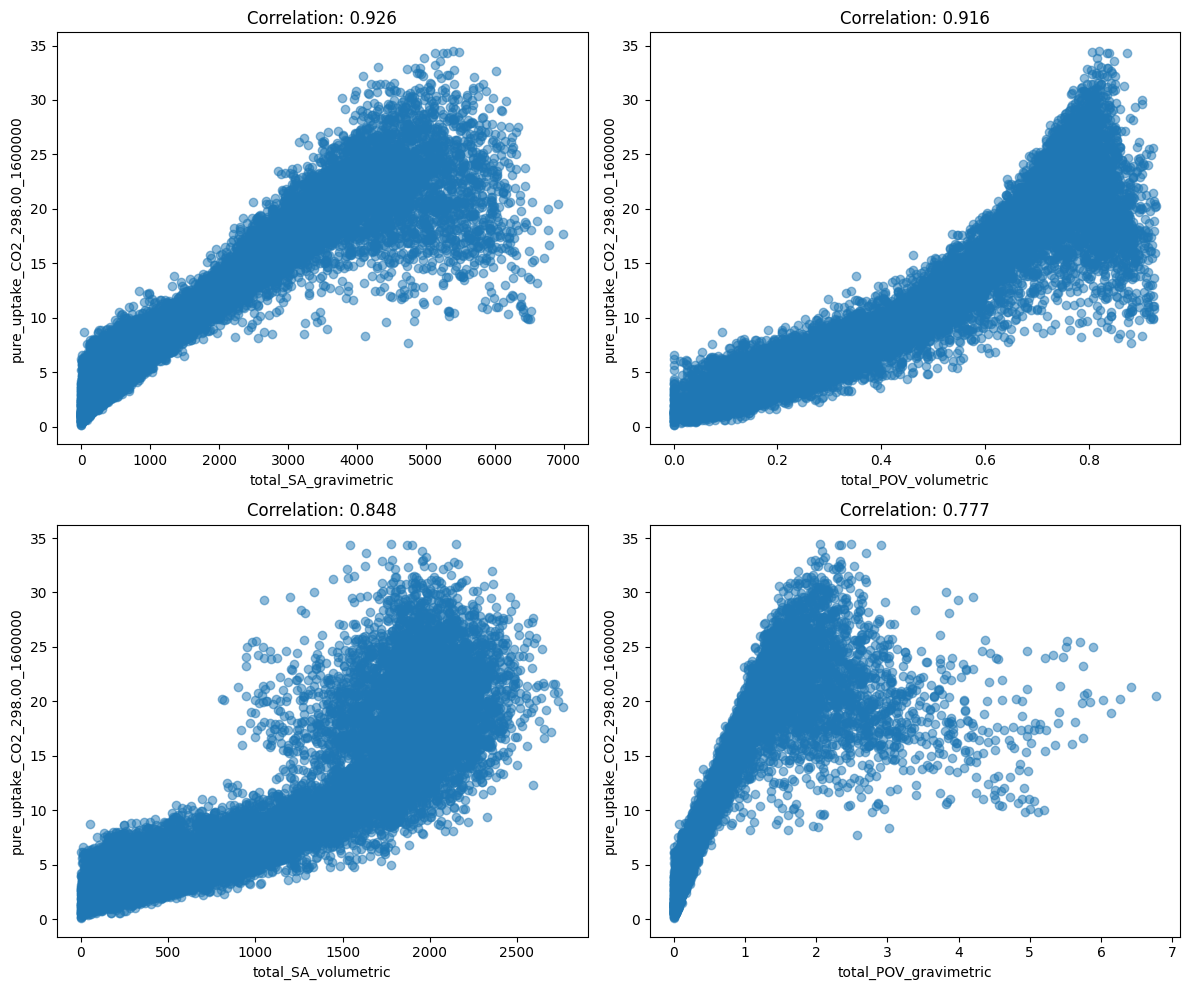

In [14]:
# Calculate Pearson correlation
pearson_corr = df_train_stratified[FEATURES + [TARGET]].corr(method='pearson')[TARGET].sort_values(ascending=False)
print("Top 10 Pearson correlations:")
print(pearson_corr.head(10))

# Calculate Spearman correlation
spearman_corr = df_train_stratified[FEATURES + [TARGET]].corr(method='spearman')[TARGET].sort_values(ascending=False)
print("\nTop 10 Spearman correlations:")
print(spearman_corr.head(10))

# Plot some features against target
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
top_features = pearson_corr.index[1:5]  # Skip the target itself

for idx, feature in enumerate(top_features):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(df_train_stratified[feature], df_train_stratified[TARGET], alpha=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel(TARGET)
    ax.set_title(f'Correlation: {pearson_corr[feature]:.3f}')
plt.tight_layout()
plt.show()

 ${\textsf{Short Exercise}}$

In this exercice, we have computed two correlation values, the Pearson and the Spearman. The difference between the two underlies in the fact that the Pearson correlation measures a linear relationship and the other the monotonic relationship, hence looks if the relationship between two variable always moves in the same direction<sup>1</sup>. 

 On the above figures, we have plotted the features with the highest correlation. It can be seen that the highest correlation can be found for the surface area per unit mass and the pore volume per unit of volume. This could have been predicted as the uptake of carbon dioxide increases as the volume of the pores increases and a larger surface area would lead to more carbon dioxide absorption. 

 The reason why the correlation could be a problem is because in most of the machine learning models, features are often considered to be matrices. When the features are correlated the information becomes redundant and less data can be used to train the model, in other words the correlation decreases the rank. 

[1]: A comparison of the Pearson and Spearman correlation methods (no date). Available at: https://support.minitab.com/en-us/minitab/help-and-how-to/statistics/basic-statistics/supporting-topics/correlation-and-covariance/a-comparison-of-the-pearson-and-spearman-correlation-methods/ (Accessed: 17 October 2025).


## 4. Baselines

For machine learning, it is important to have some *baselines* to which one then compares the results of a model. Think of a classification model for some rare disease where we only have 1% postives. A classification model that only predictes the negatives *all the time* will still have a amazingly high accuracy. To be able to understand if our model is really better than such a simple prediction we need to make the simple prediction first. This is what we call a baseline.

A baseline could be a really simple model, a basic heuristic or the current state of the art.
this. We will use a heuristic.

For this we use sklearn `Dummy` objects that simply calculate the mean, the median or the most frequent case of the training set, when you run the `fit()` method on them (which takes the features matrix $\mathbf{X}$ and the labels $\mathbf{y}$ as arguments.
This is, the prediction of a `DummyRegressor` with `mean` strategy will always be the mean, independent of the input (it will not look at the feature matrix!). 

Instead of using those `sklearn` objects you could also just manually compute the the mean or median of the dataset. But we will use those objects as we can learn in this way how to use estimators in `sklearn` and it is also allows you to test your full pipeline with different (baseline) models. 
What does this mean? In practice this means that you can use all the regression and classification models shown in the figure below in the same way, they will all have a `fit()` method that accepts `X` and `y` and a predict method that accepts `X` and returns the predictions. 


<img src="https://scikit-learn.org/stable/assets/ml_map.png" alt="ML Map" width="800"/>

The estimator objects can be always used in the same way 

<img src="https://static.packt-cdn.com/products/9781789800265/graphics/d49a2e95-8f22-42ed-89f1-474b3d028787.png" alt="ML Map" width="400"/>

Using these objects, instead of the mean directly, allows you to easily swap them with other models in pipelines, where one chains many data transformation steps (see section 6).

### 4.1. Build dummy models

${\textsf{Short Question}}$
- If you call `.fit(X, y)` on a `DummyRegressor` does it actually use the `X`? If not, why is there still the place for the `X` in the function? If yes, how does it use it?

$\textsf{Short Exercise}$
- Create [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) instances for  `mean`, `median`. (e.g. `dummyinstance = DummyRegressor(strategy='mean')`)
- Train them on the training data (`dummyinstance.fit(df_train[FEATURES], df_train[TARGET])`)

${\textsf{Answer}}$

The fit() method is where all the model training is done<sup>2</sup>. This method takes the training data as arguments. The model is fitted using X and y. X is an array-like shape of (n_samples, n_features) representing the training set and y is also an array-like shape of (n_samples) or (n_samples, n_outputs) representing the target values<sup>3</sup>. However, the objects do not hold any reference to X and y. In most strategies such as MAE and MSE we do not take X into acount and only look at y. Hence X, is ignored while calculating the predictions. 

The method still uses the X parameter because this allows the sklearn library to remain consistant across all estimators. This way the DummyRegressor can be used to compute other tools such as cross-validations. 

[2]: Developing scikit-learn estimators (no date) scikit-learn. Available at: https://scikit-learn/stable/developers/develop.html (Accessed: 17 October 2025).

[3]: DummyRegressor (no date) scikit-learn. Available at: https://scikit-learn/stable/modules/generated/sklearn.dummy.DummyRegressor.html (Accessed: 17 October 2025).


<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to create <code>DummyRegressor</code> you can for example use <code> dummyregressor_mean = DummyRegressor(strategy='mean') </code> </li>
    <li> to see the implementation of the <code>DummyRegressor</code> you can check out <a href="https://github.com/scikit-learn/scikit-learn/blob/73732e5a0bc9b72c7049dc699d69aaedbb70ef0a/sklearn/dummy.py#L391"> the source code on GitHub</a> </li>
</ul>
</details>

In [15]:
# Build DummyRegressors
dummyregressor_mean = DummyRegressor(strategy='mean')
dummyregressor_median = DummyRegressor(strategy='median')

In [16]:
# Fit Dummy Regressors
dummyregressor_mean.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
dummyregressor_median.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

,strategy,'median'
,constant,None
,quantile,None


#### Evaluate the performance of the dummy models

 ${\textsf{Short Exercise}}$
- Calculate maximum error, mean absolute error and mean square error for the dummy regressors on training and test set. What would you expect those numbers to be?
- Do the actual values surprise you? 
- What does this mean in practice for reporting of metrics/the reasoning behind using baseline models

It can be handy to store our metrics of choice in a nested dictionary ([Python dictionaries are key-value pairs](https://www.tutorialspoint.com/python/python_dictionary.htm)): 

```python
{
    'dummyestimator1': {
                        'metric_a_key': metric_a_value, 
                        'metric_b_key': metric_b_value
                    },
    'dummyestimator2': {
                        'metric_a_key': metric_a_value, 
                        'metric_b_key': metric_b_value
                    },
 }
``` 

You will now write functions `get_regression_metrics(model, X, y_true)` that compute the metrics and return this dictionary for a given model. The `predict` method takes the feature matrix $\mathbf{X}$ as input.

In them, we calculate 

$\mathrm {MAE} =\frac{\sum _{i=1}^{n}\left|Y_{i}-\hat{y}_{i}\right|}{n}.$

and 

$\mathrm {MSE} = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}.$ 

where $\hat{y}$ are the predictions and, $Y_{i}$ the true values.

as well as the maximum error.

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to perform a prediction using a estimator object, you can call <code> classifier.predict(X) </code> </li>
    <li> to calculate metrics, you can for example call <code>accuracy_score(true_values, predicted_values) </code> </li>
</ul>
</details>

In [17]:
def get_regression_metrics(model, X, y_true):
    """
    Get a dicionary with regression metrics:

    model: sklearn model with predict method
    X: feature matrix
    y_true: ground truth labels
    """
    y_predicted = model.predict(X)

    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    maximum_error = max_error(y_true, y_predicted)

    metrics_dict = {
        'mae': mae,
        'mse': mse,
        'max_error': maximum_error
    }

    return metrics_dict

In [18]:
dummy_regressors = [
    ('mean', dummyregressor_mean),
    ('median', dummyregressor_median)
]

In [19]:
dummy_regressor_results_test = {} # initialize empty dictionary
dummy_regressor_results_train = {}

# loop over the dummy_regressor list
# if you have a tuple regressorname, regressor = (a, b) that is automatically expanded into the variables
# a = regressorname, b = regressor
for regressorname, regressor in dummy_regressors:
    print(f"Calculating metrics for {regressorname}")
    dummy_regressor_results_test[regressorname] = get_regression_metrics(regressor, df_test_stratified[FEATURES], df_test_stratified[TARGET])
    dummy_regressor_results_train[regressorname] = get_regression_metrics(regressor, df_train_stratified[FEATURES], df_train_stratified[TARGET])

print(dummy_regressor_results_test)

Calculating metrics for mean
Calculating metrics for median
{'mean': {'mae': 6.23570655480622, 'mse': 52.37955580408542, 'max_error': 20.950406086755144}, 'median': {'mae': 6.15904320182382, 'mse': 54.20248538065805, 'max_error': 22.364281338299996}}


## 5. Build actual regression models

Let's build a simple [kernel ridge regression (KRR)](https://emtiyaz.github.io/pcml15/kernel-ridge-regression.pdf) machine learning model and train it with our raw data.
You can try different kernels, but we recommend to start with the Gaussian radial basis function ('rbf') kernel.
 
 $\color{DarkBlue}{\textsf{Short Question}}$
- Do you expect this model to perform better than the dummy models?\
Yes, most likely because KRR can learn nonlinear relationships between descriptors and $CO_2$ uptake, while dummy regressors always predict a central value (mean/median) and ignore X. However, if the features carry little signal or the dataset is extremely small/noisy, KRR can perform similarly or even worse (overfitting) than the dummy baselines.
- Train it and then calculate the performance metrics on the training and test set. How do they compare to the performance of the dummy models?\
##### KRR Performance Metrics:

| Metric       | Training | Test  |
|-------------|----------|-------|
| MAE         | 5.88     | 11.70 |
| MSE         | 48.26    | 189.51|
| Max Error   | 17.25    | 32.75 |

##### Dummy Regressors Performance Metrics (Test Set):

| Metric       | Dummy Mean | Dummy Median |
|-------------|------------|--------------|
| MAE         | 6.24       | 6.16         |
| MSE         | 52.38      | 54.20        |
| Max Error   | 20.95      | 22.36        |

Comparison:
- On the training set, KRR achieves lower errors than the dummy models, as expected.
- On the test set, the KRR model has a higher MAE (11.70) and MSE (189.51) compared to its training metrics, indicating some overfitting.
- Compared to the dummy regressors, KRR’s MAE on the test set (11.70) is actually higher than the dummy MAE (~6.2), meaning the model currently performs worse than simply predicting the mean or median.  
- This suggests that either the KRR model is overfitting strongly to the training data or that the current features/kernel parameters do not provide enough predictive signal for generalization.

Overall, while Kernel Ridge Regression has the potential to learn patterns in the data, in this case, it does not yet outperform the baseline dummy models on the test set. Feature scaling or additional data may be required to improve generalization.

- What is the shape of the Kernel and of the weights? (you can check your answer by looking at the `dual_coef_` attribute of the KRR instance). You can get shapes of objects using the `shape` atrribute.

##### Kernel (Gram) Matrix:

- The kernel matrix shape is `(13903, 13903)`.  
- Meaning: The model computed the similarity between every pair of the 13,903 training samples. Each entry `K[i, j]` represents how similar sample `i` is to sample `j` using the chosen RBF kernel.  
- Implication: The matrix is very large (~193 million entries), which is memory-intensive. This is typical for Kernel Ridge Regression on large datasets, as it stores all pairwise similarities.

##### Dual Coefficients (`dual_coef_`):

- The dual coefficients shape is `(13903,)`, meaning there is one weight for each training sample.  
- Each coefficient $\alpha$ determines how much that training sample contributes to predictions. The prediction for a new sample `x` is:

$$
\hat{y} = \sum_{i=1}^{13903} \alpha_i K(x_i, x)
$$

This means that training samples with larger magnitude $\alpha$ have stronger influence on the model’s predictions. KRR is effectively “memorizing” the training data in kernel space.
 

In [20]:
# Train the model with a Gaussian kernel

krr = KernelRidge(kernel='rbf')
krr.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

,alpha,1
,kernel,'rbf'
,gamma,None
,degree,3
,coef0,1
,kernel_params,None


In [21]:
#get the metrics on train and test set using the get_regression_metrics function (as above)
krr_metrics_test = get_regression_metrics(krr, df_test_stratified[FEATURES], df_test_stratified[TARGET])
krr_metrics_train = get_regression_metrics(krr, df_train_stratified[FEATURES], df_train_stratified[TARGET])
print("KRR Test Metrics:")
print(krr_metrics_test, krr_metrics_train)

KRR Test Metrics:
{'mae': 11.700920671061562, 'mse': 189.50792511509013, 'max_error': 32.748804214699994} {'mae': 5.88434044319975, 'mse': 48.25742829969019, 'max_error': 17.246056271874647}


In [22]:
from sklearn.metrics.pairwise import rbf_kernel

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
K = rbf_kernel(X_train, X_train, gamma=0.1)  # compute Gram matrix
print("Kernel (Gram) matrix shape:", K.shape)
print("Dual coefficients shape:", krr.dual_coef_.shape)

Kernel (Gram) matrix shape: (13903, 13903)
Dual coefficients shape: (13903,)


## 6. Evaluate the model performance in detail

We have trained our first machine learning model!
We'll first have a closer look at its performance, before learning how to improve it.

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Create a parity plot (true values against predictions)for the training and test data
- Plot a histogram of the distribution of the training and test errors on the training and test set. Plot the errors also as a function of the true value
- Let's assume we would like to use our model for pre-screening a library of millions of porous materials to zoom-in on those with the most promising gas uptake. Could you tolerate the errors of your model?
- Compare the parity plots for this model with the ones for the dummy models. 
Use the plotting functions below the evaluate all the following models you train.

For this exercise, it can be handy to save the results in a dictionary, e.g. 
```(python)
res_train = {
    'y true': [],
    'y pred': []
}
```

#### Answers -> à compléter la discussion 

##### Parity Plots
- The parity plots compare true uptake values against model predictions.  
- Ideally, points lie on the diagonal (perfect prediction).  
- The KRR model shows good correlation on the training set, but some scatter appears on the test set, indicating prediction errors and overfitting.

##### Error Distributions
- Histograms of training and test errors show that errors are roughly centered around zero, but the test set has a wider spread, consistent with the MAE/MSE values.  
- Plotting errors vs true values highlights where the model under- or over-predicts, revealing deviations or bias.

##### Tolerance of errors for Pre-Screening
- The parity plots and error analyses reveal that while the model performs reasonably well on the training set, its predictive capability on unseen data displays deviations. Specifically, the test parity plot indicates that the model consistently underestimates uptake at higher true values, as evidenced by the flattening of predicted values above roughly 25–30 mmol.g $^{-1}$. This underprediction suggests that the model fails to fully capture the nonlinear behavior associated with high-capacity materials, potentially due to limited representation of such cases in the training data or insufficient model complexity.
- Nevertheless, the model demonstrates strong overall correlations between predicted and true values, indicating that it captures the main structure–property trends of $CO_2$ uptake. The training and test error distributions are relatively compact, with most predictions clustering around the line of equality, particularly in the low to intermediate uptake regime. For pre-screening purposes, such behavior is acceptable since the model can effectively discriminate between poor and moderately performing materials.
- However, because the bias leads to an underestimation of the most promising candidates, this model should not be used as a definitive predictor for identifying the top-performing materials. Instead, it would be most appropriate as a first-level screening tool, narrowing down the search space for following high fidelity and accurate calculations, such as molecular simulations or experimental data.

##### Comparison to Dummy Models
- When compared to the parity plots derived from the dummy models, the improvement offered by the trained model is substantial. The dummy models, which rely on single descriptors such as total surface area or pore volume, exhibit broad scatter around the line of equality and correlations ranging only between 0.77 and 0.93 (see the plots at ). These relationships capture general physical trends but lack predictive precision, particularly at high uptake values where the data spread is considerable. In contrast, the trained model integrates multiple descriptors and learns nonlinear relationships, resulting in tighter clustering of data points and smaller deviations from the line of equality. The superior performance in both training and test sets demonstrates that the model generalizes beyond simple linear correlations and provides a more reliable mapping between material features and gas uptake behavior.  

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
<ul>
    <li> If you want to use matplotlib to make the parity plots, you can use the <a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html">hist2d function</a> </li>
    <li> To create the frequencies and the edges of a histogram, one can use <code>np.histogram</code></li>
</ul>
</details>

In [23]:
# Create dictionaries with training and test results to create parity plots
# Training results
res_train = {
    'y true': df_train_stratified[TARGET],
    'y pred': krr.predict(df_train_stratified[FEATURES])
}

res_test = {
    'y true': df_test_stratified[TARGET],
    'y pred': krr.predict(df_test_stratified[FEATURES])
}

Now, lets calculate the errors

In [24]:
res_train["error"] = res_train["y true"] - res_train["y pred"]
res_test["error"] = res_test["y true"] - res_test["y pred"]


Now, plot the parity plots and error distributions

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
If you want interactive plots, you can use the following code:
<pre><code>
hv.extension("bokeh")
hex_train = hv.HexTiles(res_train, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_test = hv.HexTiles(res_test, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_train + hex_test
</code>
</details>

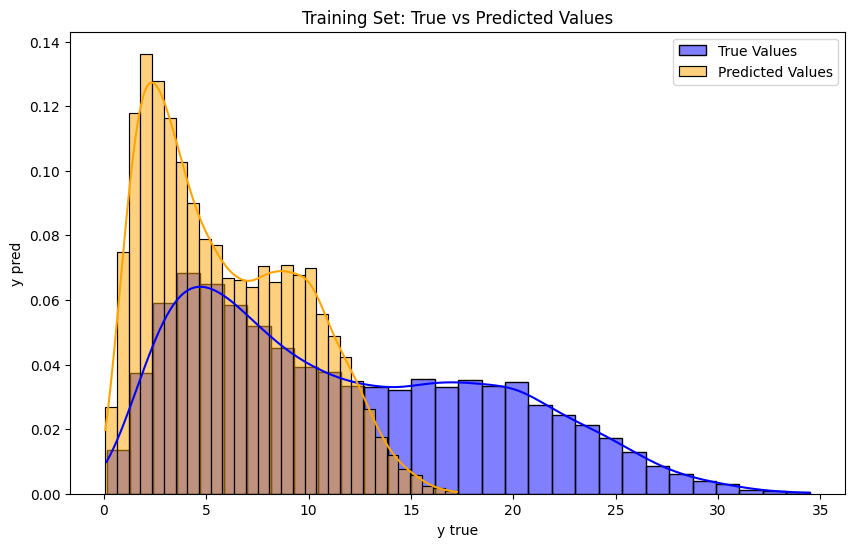

In [25]:
# plot it
def hist_density(true_values, predicted_values, xlabel='True Values', ylabel='Density', title='Density Plot'):
    plt.figure(figsize=(10, 6))
    
    # Plotting the histogram for true values
    sns.histplot(true_values, color='blue', kde=True, label='True Values', stat='density', bins=30, alpha=0.5)
    
    # Plotting the histogram for predicted values
    sns.histplot(predicted_values, color='orange', kde=True, label='Predicted Values', stat='density', bins=30, alpha=0.5)
    
    plt.xlabel(xlabel)  # Setting x-label
    plt.ylabel(ylabel)  # Setting y-label
    plt.title(title)     # Setting plot title
    plt.legend()
    plt.show()

    # plot it

hist_density(res_train['y true'], res_train['y pred'], xlabel='y true', ylabel='y pred', title='Training Set: True vs Predicted Values')


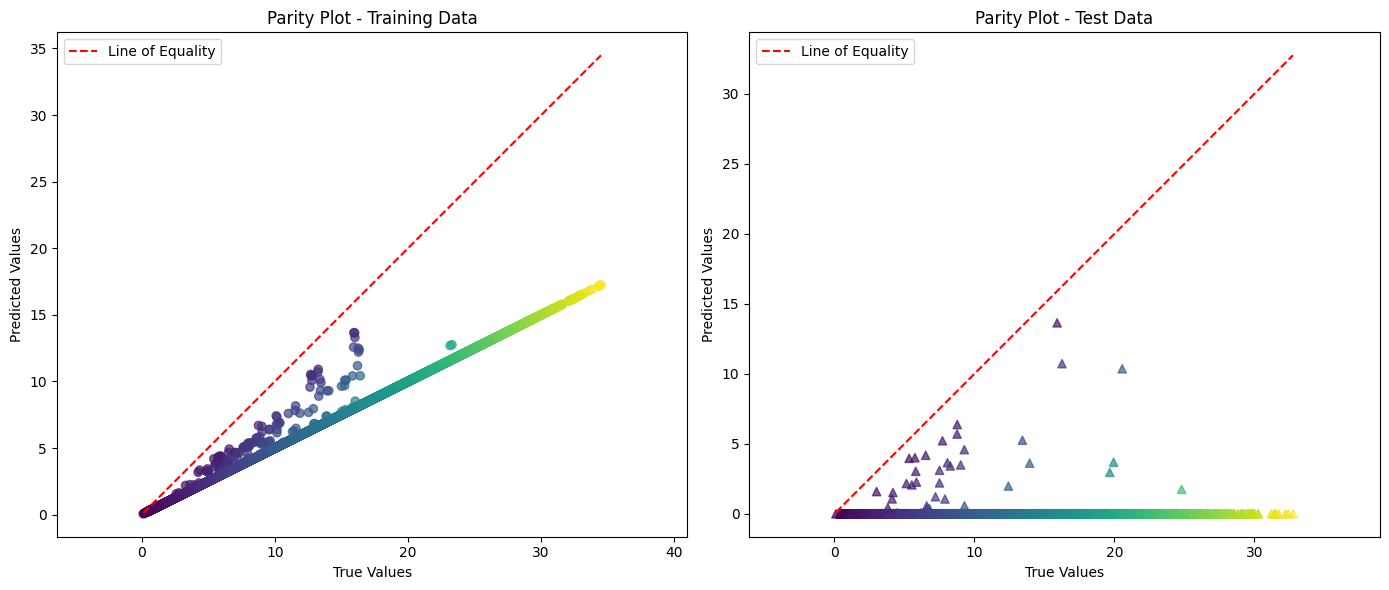

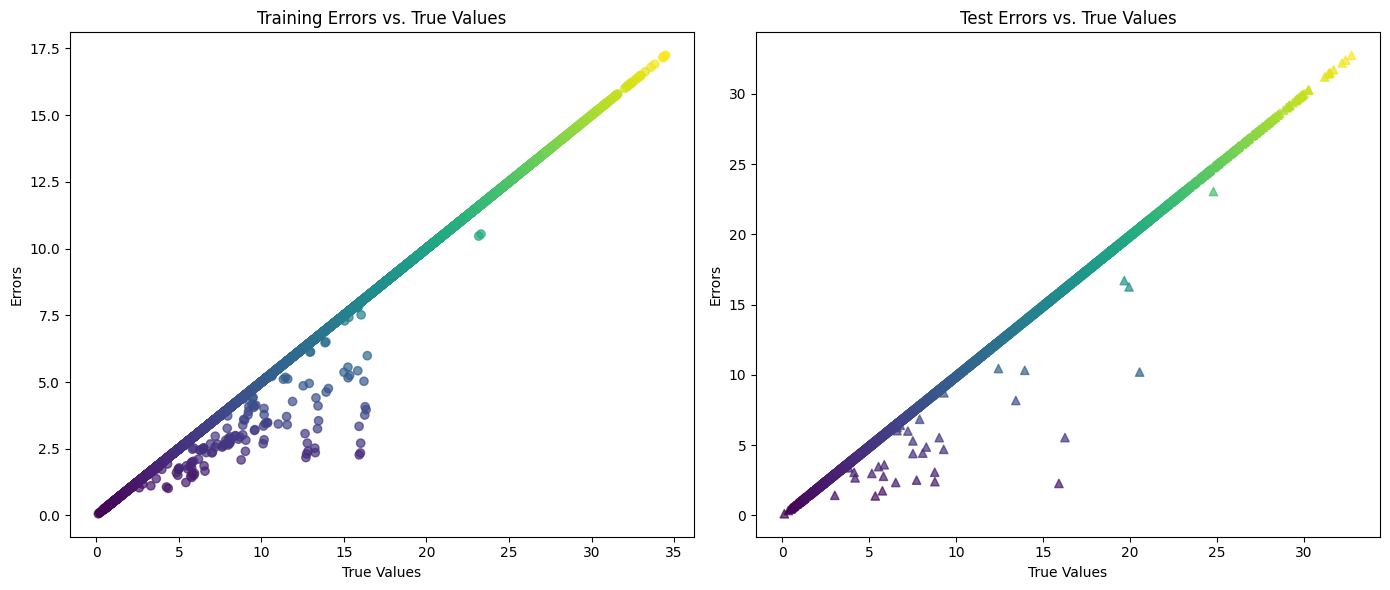

In [26]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Parity Plot for Training Data with Color Gradient based on Error
sc1 = axs[0].scatter(res_train['y true'], res_train['y pred'], 
                     alpha=0.7, 
                     c=res_train['error'], cmap='viridis',  # Color map 
                     marker='o')  # Circle markers
axs[0].plot([res_train['y true'].min(), res_train['y true'].max()],
            [res_train['y true'].min(), res_train['y true'].max()],
            color='red', linestyle='--', label='Line of Equality')
axs[0].set_title('Parity Plot - Training Data')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].legend()
axs[0].axis('equal')  # Ensure equal scaling

# Parity Plot for Testing Data with Color Gradient based on Error
sc2 = axs[1].scatter(res_test['y true'], res_test['y pred'], 
                     alpha=0.7, 
                     c=res_test['error'], cmap='viridis',  # Color map based on 'error'
                     marker='^')  # Triangle markers
axs[1].plot([res_test['y true'].min(), res_test['y true'].max()],
            [res_test['y true'].min(), res_test['y true'].max()],
            color='red', linestyle='--', label='Line of Equality')
axs[1].set_title('Parity Plot - Test Data')
axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predicted Values')
axs[1].legend()
axs[1].axis('equal')  # Ensure equal scaling

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# visualize the errors as a function of true values with color gradient
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Errors vs. True Values for Training Data with Color Gradient based on Error
sc3 = axs[0].scatter(res_train['y true'], res_train['error'], 
                     alpha=0.7, 
                     c=res_train['error'], cmap='viridis',  # Color map based on 'error'
                     marker='o')  # Circle markers
axs[0].set_title('Training Errors vs. True Values')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Errors')

# Errors vs. True Values for Testing Data with Color Gradient based on Error
sc4 = axs[1].scatter(res_test['y true'], res_test['error'], 
                     alpha=0.7, 
                     c=res_test['error'], cmap='viridis',  # Color map based on 'error'
                     marker='^')  # Triangle markers
axs[1].set_title('Test Errors vs. True Values')
axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Errors')

# Adjust layout
plt.tight_layout()

# Show the error plots
plt.show()

## 7. Improve the model 

Our training set still has a couple of issues you might have noticed:
- The feature values are not scaled (different features are measured in different units ...)
- Some features are basically constant, i.e. do not contain relevant information and just increase the dimensionality of the problem 
- Some feature distributions are skewed (which is more relevant for some models than for others ...)

$\color{DarkBlue}{\textsf{Short Question}}$
- Why might the scaling of the features be relevant for a machine learning model?

### 7.1. Standard scaling and building a first pipeline 

Given that we will now go beyond training a single model, we will build [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which are objects that can collect a selection of transformations and estimators. This makes it quite easy to apply the same set of operations to different datasets. A simple pipeline might be built as follows 

<img src="https://vitalflux.com/wp-content/uploads/2020/08/ML-Pipeline-Page-2-1024x307.png" alt="Pipeline" width="800"/>



 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Build a pipline that first performs standard scaling and then fits a KRR. Call it `pipe_w_scaling`. 
- Fit it on the training set 
- Make predictions, calculate the errors and make the parity plots

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> the <code>fit</code>, <code>predict</code> methods also work for pipelines </li>
</ul>
</details>

In [27]:
#Build Pipeline
pipe_w_scaling = Pipeline(
    [
        ('scaling', StandardScaler()),       #Scaling the features
        ('krr', KernelRidge(kernel='rbf'))               #Applying Kernel Ridge Regression
    ]
)

In [28]:
#Fit the pipeline to the training set 
pipe_w_scaling.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

,steps,"[('scaling', ...), ('krr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1
,kernel,'rbf'
,gamma,None
,degree,3


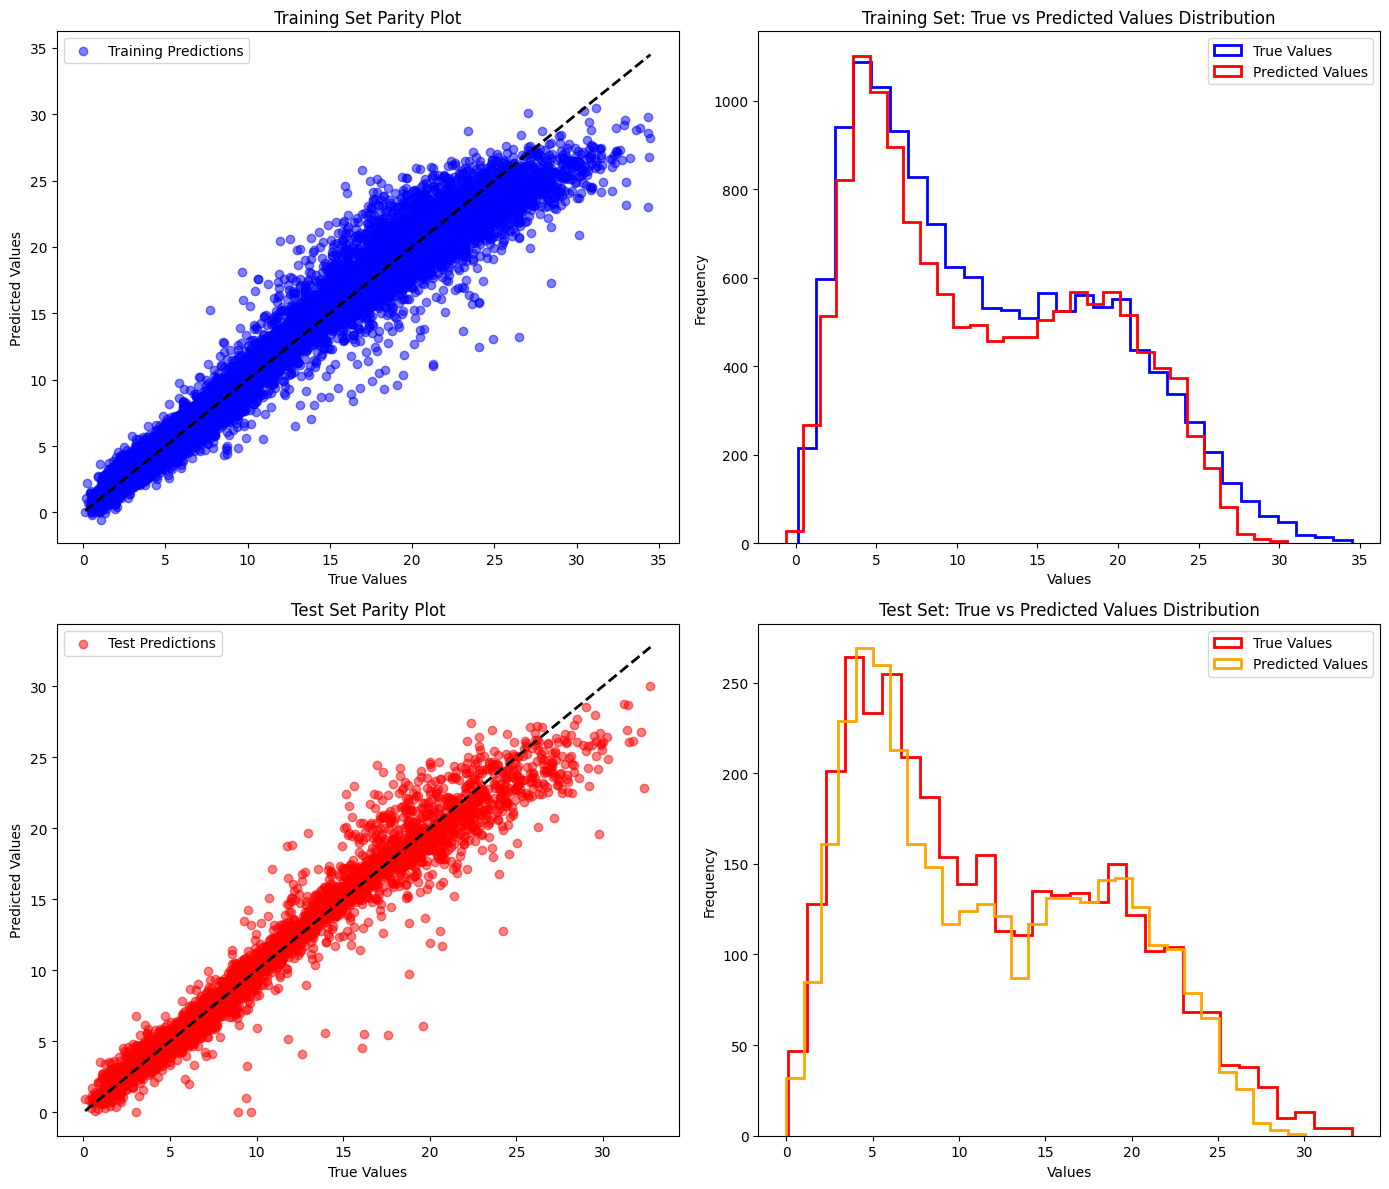

In [29]:
# Step 1: Make predictions using the fitted pipeline
y_train_pred = pipe_w_scaling.predict(df_train_stratified[FEATURES])
y_test_pred = pipe_w_scaling.predict(df_test_stratified[FEATURES])

# Step 2: Calculate errors
train_errors = df_train_stratified[TARGET] - y_train_pred
test_errors = df_test_stratified[TARGET] - y_test_pred

# Step 3: Create parity plots with histograms
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Training set parity plot
axs[0, 0].scatter(df_train_stratified[TARGET], y_train_pred, alpha=0.5, color='blue', label="Training Predictions")
axs[0, 0].plot([df_train_stratified[TARGET].min(), df_train_stratified[TARGET].max()],
               [df_train_stratified[TARGET].min(), df_train_stratified[TARGET].max()], 
               'k--', lw=2)
axs[0, 0].set_xlabel("True Values")
axs[0, 0].set_ylabel("Predicted Values")
axs[0, 0].set_title("Training Set Parity Plot")
axs[0, 0].legend()

# Training set histogram (True vs Predicted) without filling the bars
axs[0, 1].hist(df_train_stratified[TARGET], bins=30, histtype='step', color='blue', linewidth=2, label="True Values")
axs[0, 1].hist(y_train_pred, bins=30, histtype='step', color='red', linewidth=2, label="Predicted Values")
axs[0, 1].set_xlabel("Values")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_title("Training Set: True vs Predicted Values Distribution")
axs[0, 1].legend()

# Test set parity plot
axs[1, 0].scatter(df_test_stratified[TARGET], y_test_pred, alpha=0.5, color='red', label="Test Predictions")
axs[1, 0].plot([df_test_stratified[TARGET].min(), df_test_stratified[TARGET].max()],
               [df_test_stratified[TARGET].min(), df_test_stratified[TARGET].max()], 
               'k--', lw=2)
axs[1, 0].set_xlabel("True Values")
axs[1, 0].set_ylabel("Predicted Values")
axs[1, 0].set_title("Test Set Parity Plot")
axs[1, 0].legend()

# Test set histogram (True vs Predicted) without filling the bars
axs[1, 1].hist(df_test_stratified[TARGET], bins=30, histtype='step', color='red', linewidth=2, label="True Values")
axs[1, 1].hist(y_test_pred, bins=30, histtype='step', color='orange', linewidth=2, label="Predicted Values")
axs[1, 1].set_xlabel("Values")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("Test Set: True vs Predicted Values Distribution")
axs[1, 1].legend()

# Adjust layout for better display
plt.tight_layout()

# Show the plots
plt.show()


### 7.2. Hyperparameter optimization

A key component we did not optimize so far are hyperparameters. Those are parameters of the model that we usually cannot learn from the data but have to fix before we train the model. 
Since we cannot learn those parameters it is not trivial to select them. Hence, what we typically do in practice is to create another set, a "validation set", and use it to test models trained with different hyperparameters.

The most common approach to hyperparameter optimization is to define a grid of all relevant parameters and to search over the grid for the best model performance.

$\color{DarkBlue}{\textsf{Short Exercise}}$
- Think about which parameters you could optimize in the pipeline. Note that your KRR model has two parameters you can optimize. You can also switch off some steps by setting them to `None'.
- For each parameter you need to define a resonable grid to search over.
- Recall, what k-fold cross-validation does. Run the hyperparameter optimization using 5-fold cross-validation (you can adjust the number of folds according to your computational resources/impatience. It turns out at k=10 is the [best tradeoff between variance and bias](https://arxiv.org/abs/1811.12808)). 
Tune the hyperparameters until you are statisfied (e.g., until you cannot improve the cross validated error any more)
- Why don't we use the test set for hyperparameter tuning but instead test on the validation set? 
- Evaluate the model performance by calculating the performance metrics (MAE, MSE, max error) on the training and the test set.
- *Optional:* Instead of grid search, try to use random search on the same grid (`RandomizedSearchCV`) and fix the number of evaluations (`n_iter`) to a fraction of the number of evaluations of grid search. What do you observe and conclude?

 $\color{DarkRed}{\textsf{Tips}}$
- If you want to see what is happening, set the `verbosity` argument of the `GridSearchCV` object to a higher number.
 
- If you want to speed up the optimization, you can run it in parallel by setting the `n_jobs` argument to the number of workers. If you set it to -1 it will use all available cores. *Using all cores might freeze your computer if you do not have enough memory*
 
- If the optimization is too slow, reduce the number of data points in your set, the number of folds or the grid size. Note that it can also be a feasible strategy to first use a coarser grid and the a finer grid for fine-tuning.

- For grid search, you need to define a parameter grid, which is a dictionary of the following form: 
```(python)
param_grid = {
                    'pipelinestage__parameter': np.logspace(-4,1,10),
                    'pipelinestage': [None, TransformerA(), TransformerB()]
            }
```

- After the search, you can access the best model with `.best_estimator_` and the best parameters with `.best_params_` on the GridSearchCV instance. For example `grid_krr.best_estimator_`

- If you initialize the GridSearchCV instance with `refit=True` it will automatically train the model with all training data (and not only the training folds from cross-validations)

The double underscore (dunder) notation works recursively and specifies the parameters for any pipeline stage. 
For example, `ovasvm__estimator__cls__C` would specifiy the `C` parameter of the estimator in the one-versus-rest classifier `ovasvm`. 

You can print all parameters of the pipeline using `print(sorted(pipeline.get_params().keys()))`

<div class="alert alert-block alert-warning">
Be aware that tight grids will drastically increase the number of experiments you will run! In some cases, it can be useful to perform the optimization in steps, i.e., first use a coarse grid and then refine in interesting regions. 
Alternatively, there are approached like <a href="https://www.jmlr.org/papers/volume18/16-558/16-558.pdf"> hyperband <a> that dynamically adjust the number of data points.
</div>

<details>
<summary> <font color='green'>Click here for hints about pipelines and grid search</font></summary>
<ul>
    <li> You can use the <code>np.logspace</code> function to generate a grid for values that you want to vary on a logarithmic scale </li>
    <li> There are two hyperparameters for KRR: the regularization strength <code>alpha</code> and the Gaussian width  <code>gamma</code> </li>
    <li> For the regularization strength, values between 1 and 1e-3 can be reasonable. For gamma you can use the median heuristic, gamma = 1 / median, or values between 1e-3 and 1e3</li>
</ul>
</details>

In [56]:
# Define the parameter grid and the grid search object
param_grid = {
                    'scaling': [MinMaxScaler(), StandardScaler()], # test different scaling methods
                    'krr__alpha': np.logspace(-3, 0, 4),   # Regularization strength from 1e-3 to 1 
                    'krr__gamma': np.logspace(-3, 3, 7),   # Gamma values from 1e-3 to 1e3 
            }

# Define the grid search object
grid_krr = GridSearchCV(
    estimator=pipe_w_scaling,       # The pipeline to search over
    param_grid=param_grid,          # The parameter grid to optimize
    cv=2,                            # Number of folds for cross-validation
    verbose=2,                       # Verbosity level
    n_jobs=2                         # Use two cores for parallel processing
)

# Optional: Define the random search object
#random_krr = RandomizedSearchCV(
    #estimator=pipe_w_scaling,       # The pipeline to search over
    #param_distributions=param_grid,  # The parameter grid to sample from
    #n_iter=20,                       # Number of evaluations (this can be a fraction of grid size)
    #cv=5,                            # Number of folds for cross-validation
    #verbose=2,                       # Verbosity level
    #n_jobs=2                         # Use two cores for parallel processing
#)

In [57]:
# run the grid search by calling the fit method
# optional random search
# random_krr.fit(#fillme)
# run the grid search by calling the fit method

grid_krr.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

Fitting 2 folds for each of 56 candidates, totalling 112 fits


,estimator,Pipeline(step...rnel='rbf'))])
,param_grid,"{'krr__alpha': array([0.001,...0.1 , 1. ]), 'krr__gamma': array([1.e-03...e+02, 1.e+03]), 'scaling': [MinMaxScaler(), StandardScaler()]}"
,scoring,None
,n_jobs,2
,refit,True
,cv,2
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,feature_range,"(0, ...)"


In [58]:
# get the performance metrics
metrics = get_regression_metrics(grid_krr, df_train_stratified[FEATURES],df_train_stratified[TARGET]) 
print(metrics)
print(grid_krr.best_estimator_)
print(grid_krr.best_params_)
print(sorted(pipe_w_scaling.get_params().keys()))
# run the grid search by calling the fit method


{'mae': 0.6235656588517189, 'mse': 0.8435296289169807, 'max_error': 7.226624604710143}
Pipeline(steps=[('scaling', MinMaxScaler()),
                ('krr',
                 KernelRidge(alpha=np.float64(0.001), gamma=np.float64(0.1),
                             kernel='rbf'))])
{'krr__alpha': np.float64(0.001), 'krr__gamma': np.float64(0.1), 'scaling': MinMaxScaler()}
['krr', 'krr__alpha', 'krr__coef0', 'krr__degree', 'krr__gamma', 'krr__kernel', 'krr__kernel_params', 'memory', 'scaling', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'steps', 'transform_input', 'verbose']


<details>
<summary> <font color='green'>Click here for some more information about hyperparameter optimization</font></summary>
Grid search is not the most efficient way to perform hyperparamter optimization. Even <a href="http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf">random search was shown to be more efficient</a>. Really efficient though are Bayesian optimization approaches like <a href='https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)'>TPE</a>. This is implemented in the hyperopt library, which is also installed in your conda environment.
</details>

<details>
<summary> <font color='green'>Click here for hyperparameter optimization with hyperopt (advanded and optional outlook)</font></summary>
    
<b>Import the tools we need</b>
<code>
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, mix, rand, anneal, space_eval
from functools import partial
</code>    

<b>Define the grid</b>
<code>
param_hyperopt = {
    "krr__alpha": hp.loguniform("krr__alpha", np.log(0.001), np.log(10)),
    "krr__gamma": hp.loguniform("krr__gamma", np.log(0.001), np.log(10)),
}
</code> 

<b>Define the objective function</b>
<code>
def objective_function(params):
    pipe.set_params(
        **{
            "krr__alpha": params["krr__alpha"],
            "krr__gamma": params["krr__gamma"],
        }
    )
    score = cross_val_score(
        pipe, X_train, y_train, cv=10, scoring="neg_mean_absolute_error"
    ).mean()
    return {"loss": -score, "status": STATUS_OK} 
</code>

<b>We will use a search in which we mix random search, annealing and tpe</b>
<code>
trials = Trials()
mix_search = partial(
   mix.suggest,
   p_suggest=[(0.15, rand.suggest), (0.15, anneal.suggest), (0.7, tpe.suggest)],
)
</code>

<b>Now, we can minimize the objective function.</b>
<code>
best_param = fmin(
        objective_function,
        param_hyperopt,
        algo=mix_search,
        max_evals=MAX_EVALES,
        trials=trials,
        rstate=np.random.RandomState(RANDOM_SEED),
    )
</code>

</details>

## 8. Feature Engineering 

Finally, we would like to remove features with low variance. This can be done by setting a variance threshold.

$\color{DarkBlue}{\textsf{Short Question}}$
    
- What is the reasoning behind doing this? 

   A low variance for features means that they are fairly constant. However, when we train our machine learning model, we want to obtain information from our training set. If the data are too constant, we do not get useful information to train our model and to understand patterns in order to make prediction. Furthermore, these features can generate noise, as well as a larger dimension resulting in unnecessarily longer training times, since we obtain almost no useful information from them. 

- When might it go wrong and why?

    This selection by variance is useful in many cases for the reasons explained above, but there are still situations where this technique can pose a problem.\ 
    First, we are not taking "the relationship between feature variables or feature and target variables into account, which is one of the drawbacks of filter methods"<sup>1</sup>. This implies that a variable with low variance could be strongly correlated with the target but be wrongly removed.\ 
    Second, this technique does not take into account the fact that a variable may have a small variance on its own, but when combined with another variable, it becomes useful in terms of the information it provides to the model for training purposes<sup>2</sup>.\
    Third, it seems better to have standardised values rather than values with all types of units, for example.\


    à compléter/vérifier


[1]. Aman. Feature Selection in Machine Learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/ (accessed 2025-10-25).\
[2]. Feature Selection | Filter Methods. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/feature-selection-filter-methods/ (accessed 2025-10-25).

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Add a variance threshold to the pipeline (select the correct function argument)
- Use random search for hyperparameter optimization, retrain the pipeline, and calculate the performance metrics (max error, MAE, MSE) on the training and test set

In [31]:
# Define the pipeline
pipe_variance_threshold = Pipeline(
    # fillme with the pipeline steps
    [   ('scaling', StandardScaler()),       #Scaling the features
        ('variance_treshold', VarianceThreshold(0.05)),
        ('krr', KernelRidge(kernel='rbf'))               #Applying Kernel Ridge Regression
    ]
)

In [ ]:
param_grid_variance_threshold = {
                    'scaling': [None, StandardScaler()],
                    'krr__alpha': np.logspace(-3, 0, 4),   # Regularization strength from 1e-3 to 1; same as in question 7
                    'krr__gamma': np.logspace(-3, 3, 7),   # Gamma values from 1e-3 to 1e3 
                    'variance_treshold__threshold': 0.05
            }

random_variance_treshold = RandomizedSearchCV(#your pipeline, param_distributions=param_grid, n_iter=#number of evaluations,
                        cv=#number of folds, verbose=2, n_jobs=2)

In [ ]:
# Fit the pipeline and run the evaluation
random_variance_treshold.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

$\color{DarkBlue}{\textsf{Short Exercise (optional)}}$
- replace the variance threshold with a model-based feature selection 
`('feature_selection', SelectFromModel(LinearSVC(penalty="l1")))` or [any feature selection method that you would like to try](https://scikit-learn.org/stable/modules/feature_selection.html)

## 9. Saving the model

Now, that we spent so much time in optimizing our model, we do not want to loose it. 

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- use the [joblib library](https://scikit-learn.org/stable/modules/model_persistence.html) to save your model
- make sure you can load it again


In [ ]:
# Dump your model
joblib.dump(model, filename)

In [ ]:
# Try to load it again
model_loaded = joblib.load(filename)

## 10. Influence of Regularization

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- what happens if you set $\alpha$  to a really small or to large value? Why is this the case explain what the parameter means using the equation derived in the lectures?

 To test this, fix this value in one of your pipelines, retrain the models (re-optimizing the other hyperparameters) and rerun the performance evaluation.

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> Check the derivation for ridge regression and KRR in the notes. </li>
    <li> Also remember the loss landscapes we discussed in the lectures about LASSO. </li>
</ul>
</details>

## 11. Interpreting the model 

Now, that our model performs decently, we would like to know which features are mainly responsible for this, i.e. how the model performs its reasoning. 

One method to do so is the [permutation feature importance technique](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

$\color{DarkBlue}{\textsf{Short question}}$

We use both descriptors that encode the pore geometry (density, pore diameters, surface areas) as well as some that describe the chemistry of the MOF (the RACs). 
- Would you expect the relative importance of these features to be different for prediction of gas adsorption at high vs low gas pressure?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> <a href="https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.8b02257">An article from Diego et al.</a> (10.1021/acs.chemmater.8b02257) gives some hints.</li>
</ul>
</details>

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Complete the function `_calculate_permutation_scores` (which we took from the `sklearn` package) and which is needed to calculate the permutation feature importance using the `permutation_importance` function. 

In [ ]:
def _calculate_permutation_scores(estimator, X, y, col_idx, random_state,
                                  n_repeats, scorer):
    """Calculate score when `col_idx` is permuted. Based on the sklearn implementation

    estimator: sklearn estimator object
    X: pd.Dataframe or np.array
    y: pd.Dataframe or np.array
    col_idx: int
    random_state: int
    n_repeats: int
    scorer: function that takes model, X and y_true as arguments
    """
    random_state = check_random_state(random_state)

    X_permuted = X.copy()
    scores = np.zeros(n_repeats)
    # get the indices
    shuffling_idx = np.arange(X.shape[0])
    for n_round in range(n_repeats):
        # FILL BELOW HERE
        # shuffle them (fill in what you want to shuffle)
        random_state.shuffle(#fillme)

        # Deal with dataframes
        if hasattr(X_permuted, "iloc"):
            # .iloc selects the indices from a dataframe and you give it [row, column]
            col = X_permuted.iloc[shuffling_idx, col_idx]
            col.index = X_permuted.index
            X_permuted.iloc[:, col_idx] = col

        # Deal with numpy arrays
        else:
            # FILL BELOW HERE
            # array indexing is [row, column]
            X_permuted[:, col_idx] = X_permuted[#fillme]

        # Get the scores
        feature_score = scorer(estimator, X_permuted, y)

        # record the scores in array
        scores[n_round] = feature_score

    return scores

Nothing to change in the function below, it just call the `_calculate_permutation_scores` function you just completed. 

In [ ]:
def permutation_importance(
    estimator,
    X,
    y,
    scoring="neg_mean_absolute_error",
    n_repeats=5,
    n_jobs=2,
    random_state=None,
):
    """Permutation importance for feature evaluation
    estimator : object
        An estimator that has already been :term:`fitted` and is compatible
        with :term:`scorer`.
    X : ndarray or DataFrame, shape (n_samples, n_features)
        Data on which permutation importance will be computed.
    y : array-like or None, shape (n_samples, ) or (n_samples, n_classes)
        Targets for supervised or `None` for unsupervised.
    scoring : string, callable or None, default=None
        Scorer to use. It can be a single
        string (see :ref:`scoring_parameter`) or a callable (see
        :ref:`scoring`). If None, the estimator's default scorer is used.
    n_repeats : int, default=5
        Number of times to permute a feature.
    n_jobs : int or None, default=2
        The number of jobs to use for the computation.
        `None` means 1 unless in a :obj:`joblib.parallel_backend` context.
        `-1` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    random_state : int, RandomState instance, or None, default=None
        Pseudo-random number generator to control the permutations of each
        feature. See :term:`random_state`.
    """
    # Deal with dataframes
    if not hasattr(X, "iloc"):
        X = check_array(X, force_all_finite="allow-nan", dtype=None)

    # Precompute random seed from the random state to be used
    # to get a fresh independent RandomState instance for each
    # parallel call to _calculate_permutation_scores, irrespective of
    # the fact that variables are shared or not depending on the active
    # joblib backend (sequential, thread-based or process-based).
    random_state = check_random_state(random_state)
    random_seed = random_state.randint(np.iinfo(np.int32).max + 1)

    # Determine scorer from user options.
    scorer = check_scoring(estimator, scoring=scoring)
    # get the performance score on the unpermuted data
    baseline_score = scorer(estimator, X, y)

    # run the permuted evaluations in parallel for each column
    scores = Parallel(n_jobs=n_jobs)(
        delayed(_calculate_permutation_scores)(
            estimator, X, y, col_idx, random_seed, n_repeats, scorer
        )
        for col_idx in range(X.shape[1])
    )

    # get difference two
    importances = baseline_score - np.array(scores)

    # return the results (dictionary)
    return Bunch(
        importances_mean=np.mean(importances, axis=1),
        importances_std=np.std(importances, axis=1),
        importances=importances,
    )


 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Use your function to find the five most important features.
- Which are they? Did you expect this result?

In [ ]:
permutation_results = permutation_importance(#fillme)

In [ ]:
permutation_results["features"] = FEATURES
bars = hv.Bars(
    permutation_results, "features", ["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)
errors = hv.ErrorBars(
    permutation_results, "features", vdims=["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)

bars * errors


<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> To get the top <emph>n</emph> indices of an array <code>a</code>, you can use <code>np.argsort(a)[-n:]</code></li>
    <li> Get the feature names from the <code>FEATURES</code> list </li> 
    <li> combined this might look like <code>np.array(FEATURES)[np.argsort(a)[-n:]]</code></li>
</ul>
</details>

<details>
<summary> <font color='green'>Click here for more information on model interpretation</font></summary>
The permutation feature importance technique is not a silver bullet, e.g. there are issues with correlated features.
However, it is likely <a href='https://explained.ai/rf-importance/'>a better choice than feature importance, like impurity decrease, derived from random forests</a>).
</details>